<a href="https://colab.research.google.com/github/allensheneka/systemRx/blob/main/systemRx_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##systemRx

Project 2 - Part 2

Author:  Sheneka Allen

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import some necessary tools
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay

#import classification report
from sklearn.metrics import classification_report

#Importing the Classifiers
from xgboost import XGBClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# upload Predictive Maintenance data file 

filename = ('/content/drive/MyDrive/000 Data Science/ai4i2020.csv')
pDm_df = pd.read_csv(filename)
pDm_df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [4]:
# correct or rename column

# Modified code: https://www.statology.org/pandas-rename-columns/
pDm_df.rename(columns = {'UDI':'UID'}, inplace = True)
pDm_df.head()

,UID,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [5]:
pDm_df.duplicated().sum()

0

In [6]:
pDm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UID                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [7]:
# Check for inconsistencies
pDm_df['Type'].value_counts()

L    6000
M    2997
H    1003
Name: Type, dtype: int64

###Type values are good.

#Explore machine failures in dataset

In [8]:
# Modified code to check dataframe for a specific value: 
# https://thispointer.com/pandas-check-if-a-value-exists-in-a-dataframe-using-in-not-in-operator-isin/

pDm_df.isin([1]).any()

UID                         True
Product ID                 False
Type                       False
Air temperature [K]        False
Process temperature [K]    False
Rotational speed [rpm]     False
Torque [Nm]                False
Tool wear [min]            False
Machine failure             True
TWF                         True
HDF                         True
PWF                         True
OSF                         True
RNF                         True
dtype: bool

###UID is just a unique identifier for the product, so '1' in its column does not indicate machine failure.

###Machine failure, TWD, HDF, PWF, OSF, RNF all returned boolean 'True' for '1' value or failure in their columns.

In [9]:
#determine total number of Machine failures in dataset
pDm_df['Machine failure'].value_counts()

0    9661
1     339
Name: Machine failure, dtype: int64

###There is a total of 339 Machine failures in this dataset

In [10]:
#tool wear failure row count resulting in machine failure
pDm_df.groupby(['Machine failure', 'TWF']).count()

UID  Product ID  Type  Air temperature [K]  \
Machine failure TWF                                                
0               0    9661        9661  9661                 9661   
1               0     293         293   293                  293   
                1      46          46    46                   46   

                     Process temperature [K]  Rotational speed [rpm]  \
Machine failure TWF                                                    
0               0                       9661                    9661   
1               0                        293                     293   
                1                         46                      46   

                     Torque [Nm]  Tool wear [min]   HDF   PWF   OSF   RNF  
Machine failure TWF                                                        
0               0           9661             9661  9661  9661  9661  9661  
1               0            293              293   293   293   293   293  
                1             46               46    46    46    46    46

###Tool wear failures are 13.56% causal of Machine failures.

In [11]:
#heat dissipation failure row count resulting in machine failure
pDm_df.groupby(['Machine failure', 'HDF']).count()

UID  Product ID  Type  Air temperature [K]  \
Machine failure HDF                                                
0               0    9661        9661  9661                 9661   
1               0     224         224   224                  224   
                1     115         115   115                  115   

                     Process temperature [K]  Rotational speed [rpm]  \
Machine failure HDF                                                    
0               0                       9661                    9661   
1               0                        224                     224   
                1                        115                     115   

                     Torque [Nm]  Tool wear [min]   TWF   PWF   OSF   RNF  
Machine failure HDF                                                        
0               0           9661             9661  9661  9661  9661  9661  
1               0            224              224   224   224   224   224  
                1            115              115   115   115   115   115

###Heat dissipation failure is the #1 independent failure type resulting in Machine failures, roughly 33.9% causal.

In [12]:
#power failure row count resulting in machine failure
pDm_df.groupby(['Machine failure', 'PWF']).count()

UID  Product ID  Type  Air temperature [K]  \
Machine failure PWF                                                
0               0    9661        9661  9661                 9661   
1               0     244         244   244                  244   
                1      95          95    95                   95   

                     Process temperature [K]  Rotational speed [rpm]  \
Machine failure PWF                                                    
0               0                       9661                    9661   
1               0                        244                     244   
                1                         95                      95   

                     Torque [Nm]  Tool wear [min]   TWF   HDF   OSF   RNF  
Machine failure PWF                                                        
0               0           9661             9661  9661  9661  9661  9661  
1               0            244              244   244   244   244   244  
                1             95               95    95    95    95    95

###Power failure is the #3 independent failure type resulting in Machine failure, roughly 28.02% causal

In [13]:
#overstrain failure row count resulting in machine failure
pDm_df.groupby(['Machine failure', 'OSF']).count()

UID  Product ID  Type  Air temperature [K]  \
Machine failure OSF                                                
0               0    9661        9661  9661                 9661   
1               0     241         241   241                  241   
                1      98          98    98                   98   

                     Process temperature [K]  Rotational speed [rpm]  \
Machine failure OSF                                                    
0               0                       9661                    9661   
1               0                        241                     241   
                1                         98                      98   

                     Torque [Nm]  Tool wear [min]   TWF   HDF   PWF   RNF  
Machine failure OSF                                                        
0               0           9661             9661  9661  9661  9661  9661  
1               0            241              241   241   241   241   241  
                1             98               98    98    98    98    98

###Overstrain failure is the #2 independent failure type resulting in Machine failures, roughly 28.91% causal.

In [14]:
#random failure resulting in machine failure
pDm_df.groupby(['Machine failure', 'RNF']).count()

UID  Product ID  Type  Air temperature [K]  \
Machine failure RNF                                                
0               0    9643        9643  9643                 9643   
                1      18          18    18                   18   
1               0     338         338   338                  338   
                1       1           1     1                    1   

                     Process temperature [K]  Rotational speed [rpm]  \
Machine failure RNF                                                    
0               0                       9643                    9643   
                1                         18                      18   
1               0                        338                     338   
                1                          1                       1   

                     Torque [Nm]  Tool wear [min]   TWF   HDF   PWF   OSF  
Machine failure RNF                                                        
0               0           9643             9643  9643  9643  9643  9643  
                1             18               18    18    18    18    18  
1               0            338              338   338   338   338   338  
                1              1                1     1     1     1     1

###Random failures are .294% causal of Machine failures.

###Oddly, 18 random failures did NOT result in a Machine failures.

#Visualizations - Exploratory Data Analysis

In [15]:
# use pandas.melt to reshape the dataframe and visualize causal relationship 
# between independent failures and machine failure

# Modified code: https://stackoverflow.com/questions/38807895/seaborn-multiple-barplots,
# https://pandas.pydata.org/docs/reference/api/pandas.melt.html

new_pDm_df = pd.melt(pDm_df, id_vars=['Machine failure'], value_vars=['TWF', 'HDF', 'PWF', 'OSF', 'RNF'], 
                     var_name='Type failure', value_name='Type failure value')

new_pDm_df.head()



,Machine failure,Type failure,Type failure value
0,0,TWF,0
1,0,TWF,0
2,0,TWF,0
3,0,TWF,0
4,0,TWF,0


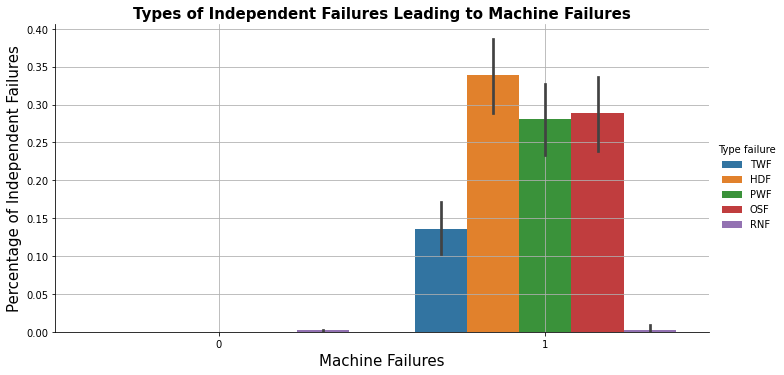

In [16]:
# create a barplot explaining causes for machine failures
sns.catplot(x='Machine failure', y='Type failure value', hue='Type failure', data=new_pDm_df, kind='bar', height=5, aspect=2)
plt.grid()
plt.title('Types of Independent Failures Leading to Machine Failures', fontweight='bold', fontsize=15)
plt.xlabel('Machine Failures', fontsize=15)
plt.ylabel('Percentage of Independent Failures', fontsize=15);

###This barplot shows Type independent failure totals (by percent) and clearly graphs the TOP 3 categories:


1.   HDF which precede ~33% of machine failures (1)
2.   OSF which precede ~28% of machine failures
3.   PWF which precede ~26% of machine failures

###A very small percentage of Random Failures - RNF - (about .001%) occurred but they did not cause a Machine Failure (0 = no machine failure).

###Although the machine model does not distinguish between which indepedent failure triggers a machine failure, I decided to keep their columns to investigate which indepedent failure occur most frequently in this dataset.  This could provide insight into common precursors to full machine failure.

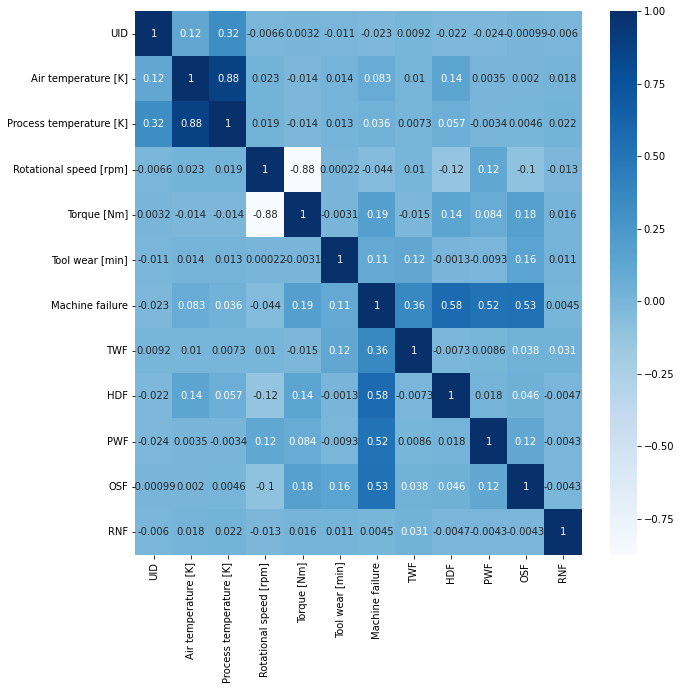

In [17]:
#create a heatmap variable
corr = pDm_df.corr()

# add correlation coefficients to heatmap with annot = True
plt.subplots(figsize=(10,10))
sns.heatmap(corr, cmap = 'Blues', annot = True);

###This heatmap further confirms that HDF, OSF and PWF independent failures (scores .58, .53, .52, respectively) are strongly correlated with Machine Failure

###Rotational Temperature and Air Temperature have a strong postive correlation with .88 scores

###Rotational Speed and Torque have a strong negative correlation with a -.88 score

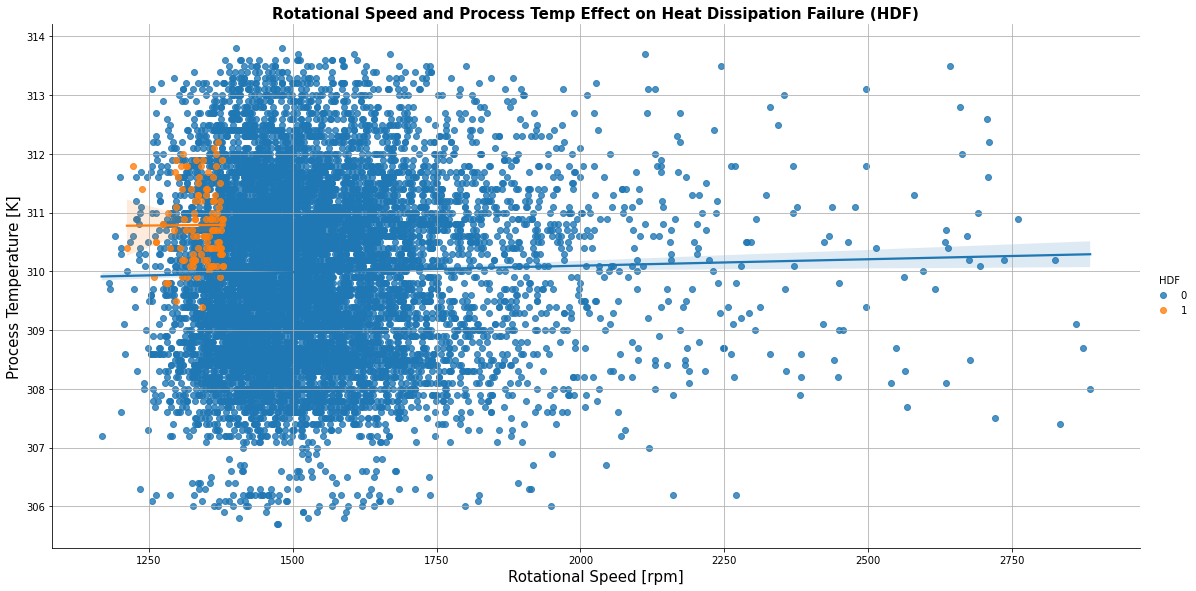

In [18]:
# explore multiple linear regression plot for Process temperature and Rotational speed effect on HDF

sns.lmplot(data=pDm_df, x='Rotational speed [rpm]', y='Process temperature [K]', hue='HDF', height=8, aspect=2)
plt.grid()
plt.title('Rotational Speed and Process Temp Effect on Heat Dissipation Failure (HDF)', fontweight='bold', fontsize=15)
plt.xlabel('Rotational Speed [rpm]', fontsize=15)
plt.ylabel('Process Temperature [K]', fontsize=15);

###This unique scatterplot allows me to explore interactions with categorical variables and it seems to show that the HDF type failure occurs most when between 1250-1375 rpm Rotational Speed and 309.5 - 312 kelvin Process Temperature.

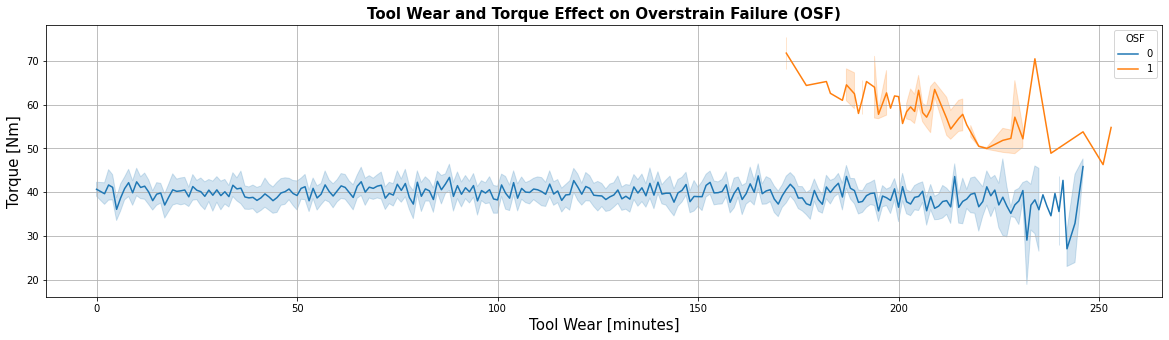

In [19]:
# explore Tool wear and torque on OSF 
plt.subplots(figsize=(20,5))
sns.lineplot(data=pDm_df, x='Tool wear [min]', y='Torque [Nm]', hue='OSF')
plt.title('Tool Wear and Torque Effect on Overstrain Failure (OSF)', fontweight='bold', fontsize=15)
plt.grid()
plt.xlabel('Tool Wear [minutes]', fontsize=15)
plt.ylabel('Torque [Nm]', fontsize=15);

###Based on this lineplot, Overstrain Failures (Tool Wear x Torque) occur most frequently between 11,550 - 12,000 min-Nm or between 165 - 250 Tool Wear min and 48 - 70 Torque Nm.

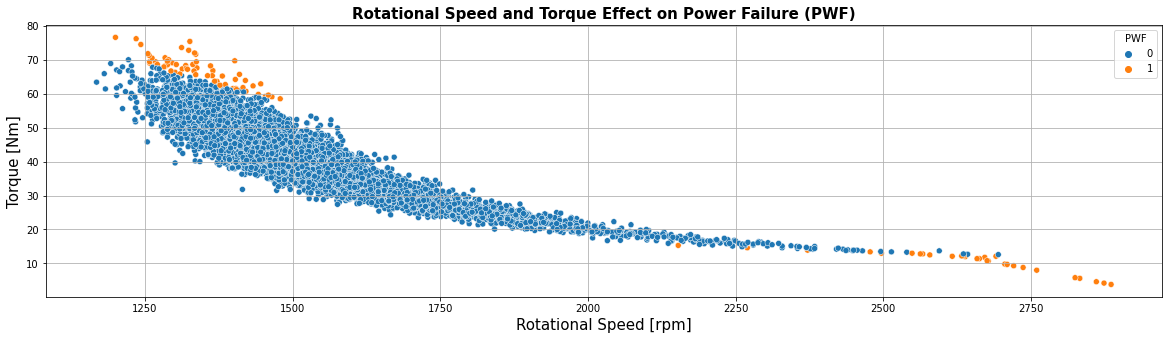

In [20]:
# explore Rotational speed and torque effect on PWF
plt.subplots(figsize=(20,5))
sns.scatterplot(data=pDm_df, x='Rotational speed [rpm]', y='Torque [Nm]', hue='PWF')
plt.title('Rotational Speed and Torque Effect on Power Failure (PWF)', fontweight='bold', fontsize=15)
plt.grid()
plt.xlabel('Rotational Speed [rpm]', fontsize=15)
plt.ylabel('Torque [Nm]', fontsize=15);

###Interestingly, this chart shows PWF (Torque x Speed (in radians/sec)) and ultimately Machine Failure occurs most in two instances: 

1.  Low Rotational Speed and High Torque (1250-1500 rpm and 60-75 Nm) OR PWF above ~7853 Watts

2.  High Rotational Speed and Low Torque (2500-2875 rpm and 3-12 Nm) OR PWF below ~3612 Watts



#Prepare data for Machine Learning

In [21]:
pDm_df['Type'].replace({'L': 0, 'M': 1, 'H': 2}, inplace=True)
pDm_df['Type'].value_counts()

0    6000
1    2997
2    1003
Name: Type, dtype: int64

In [22]:
# Align all datatypes with data dictionary
pDm_df['Type'] = pDm_df['Type'].astype(object)

In [23]:
# Determine target(y) and features(X) vectors
X = pDm_df.drop(columns=['Product ID', 'Machine failure'])
y = pDm_df['Machine failure']

X.head()

,UID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,1,1,298.1,308.6,1551,42.8,0,0,0,0,0,0
1,2,0,298.2,308.7,1408,46.3,3,0,0,0,0,0
2,3,0,298.1,308.5,1498,49.4,5,0,0,0,0,0
3,4,0,298.2,308.6,1433,39.5,7,0,0,0,0,0
4,5,0,298.2,308.7,1408,40.0,9,0,0,0,0,0


In [24]:
#Split the data into training and validation sets

#Since such a hugh imbalance between common and minority class, allocated 35% of data to test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#Class Balance

In [25]:
#Check the balance of classes
pDm_df['Machine failure'].value_counts()

0    9661
1     339
Name: Machine failure, dtype: int64

In [40]:
print(y.value_counts(normalize=True))

0    0.9661
1    0.0339
Name: Machine failure, dtype: float64


##So, just 3.39% of model predictions are actual machine failures ('positive' class).  Based on this dataset, these systems rarely have machine failures and are essentially in good 'health'.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


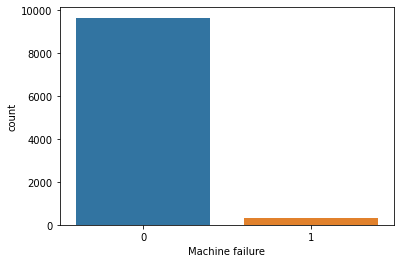

In [26]:
# visualize the target variable
sns.countplot(pDm_df['Machine failure']);

###Huge data imbalance!  Model predictions will be almost 97% accurate since the most common class (NON-machine failures, 0) is so large, not necessarily because the model is good.  Will need to explore the model's training and test prediction performance using classification metrics.

##Select data for preprocessing, create pipeline, fit training data to model

In [27]:
cat_select = make_column_selector(dtype_include='object')
num_select = make_column_selector(dtype_include='number')

# add (scaler, selector) to preprocessor
preprocess = ColumnTransformer(transformers=[('scaler', MinMaxScaler(), num_select),
                                             ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_select)],
                               remainder = 'drop')

In [28]:
# create pipeline with preprocessor and XGB model
xgb_pipe = Pipeline(steps=[('preprocessor', preprocess), 
                           ('model', XGBClassifier())])

In [29]:
# fit model to data
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9b7be0a090>),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9b7be0a890>)])),
                ('model', XGBClassifier())])

In [30]:
# predict values for the training and test set
train_preds = xgb_pipe.predict(X_train)
test_preds = xgb_pipe.predict(X_test)

##Visualize Classifier Model Performance

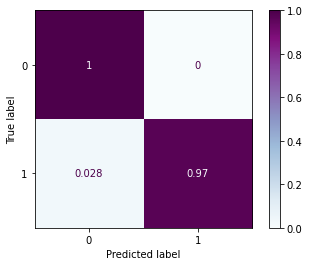

In [39]:
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, cmap='BuPu', normalize='true');

In [37]:
#Use classification_report() to print a report of several metrics for all classes at once
#for the model

test_report_xgb = classification_report(y_test, test_preds)
print('Classification Reporting for Test Set (XGB):')
print(test_report_xgb)

Classification Reporting for Test Set (XGB):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2428
           1       1.00      0.97      0.99        72

    accuracy                           1.00      2500
   macro avg       1.00      0.99      0.99      2500
weighted avg       1.00      1.00      1.00      2500

